In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import seaborn as sns
import arviz as ar

sns.set_style('whitegrid')

### Linear Regression

In [5]:
size = 200
true_β0 = 1
true_β1 = 2

x = np.linspace(0, 1, size)
y_truth = true_β0 + true_β1 * x
y = y_truth + np.random.normal(loc=0, scale=0.5, size=size)

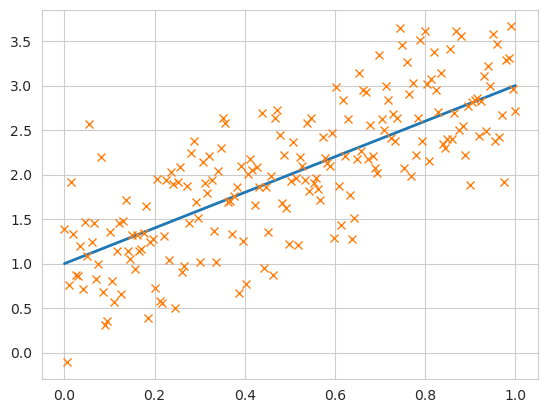

In [21]:
plt.plot(x, y_truth, lw=2)
plt.plot(x, y, 'x')

In [66]:
with pm.Model() as model:
    tau = pm.Gamma("tau", alpha=1, beta=10)
    intercept = pm.Normal("intercept", mu=0, tau=1/40)
    x_coeff = pm.Normal("x", mu=0, tau=1/40)

    likelihood = pm.Normal("y", mu=intercept + x_coeff * x, tau=tau, observed=y)

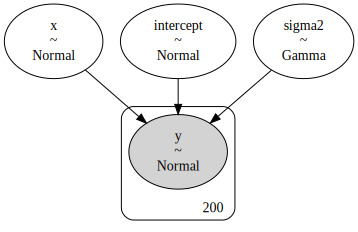

In [27]:
pm.model_to_graphviz(model)

In [97]:
with model:
    prior_samples = pm.sample_prior_predictive(50)

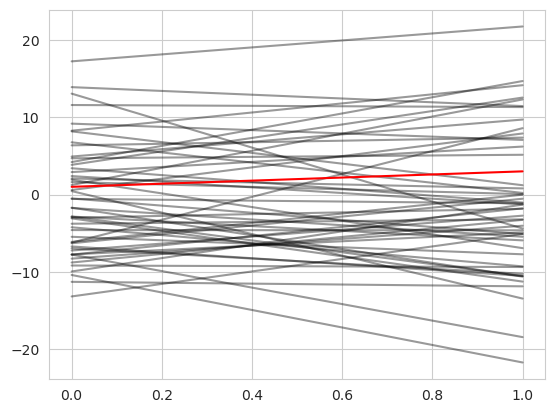

In [101]:
_, ax = plt.subplots()
for a, b in zip(prior_samples['intercept'], prior_samples['x']):
    y1 = a + b * x
    ax.plot(x, y1, c='k', alpha=0.4)
ax.plot(x, y_truth, c='r')

In [67]:
with model:
    trace = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, intercept, tau]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


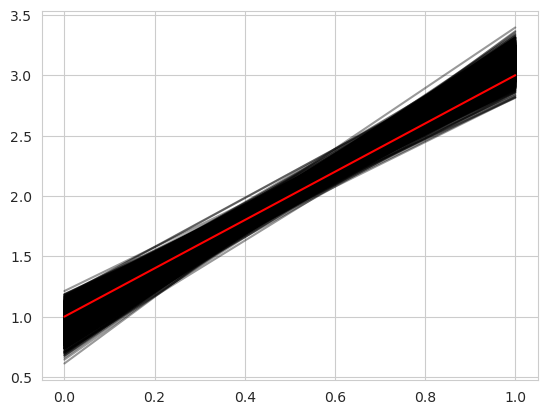

In [114]:
_, ax = plt.subplots()
for a, b in zip(trace['posterior']['intercept'][0].to_numpy(), trace['posterior']['x'][0].to_numpy()):
    y1 = a + b * x
    ax.plot(x, y1, c='k', alpha=0.4)
ax.plot(x, y_truth, c='r')

/home/ztang484/workplace/duke/sta571-fa22/project/env/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:213: UserWarning: A valid var_name should be provided, found {'i'} expected from {'tau', 'x', 'intercept'}
  warnings.warn(


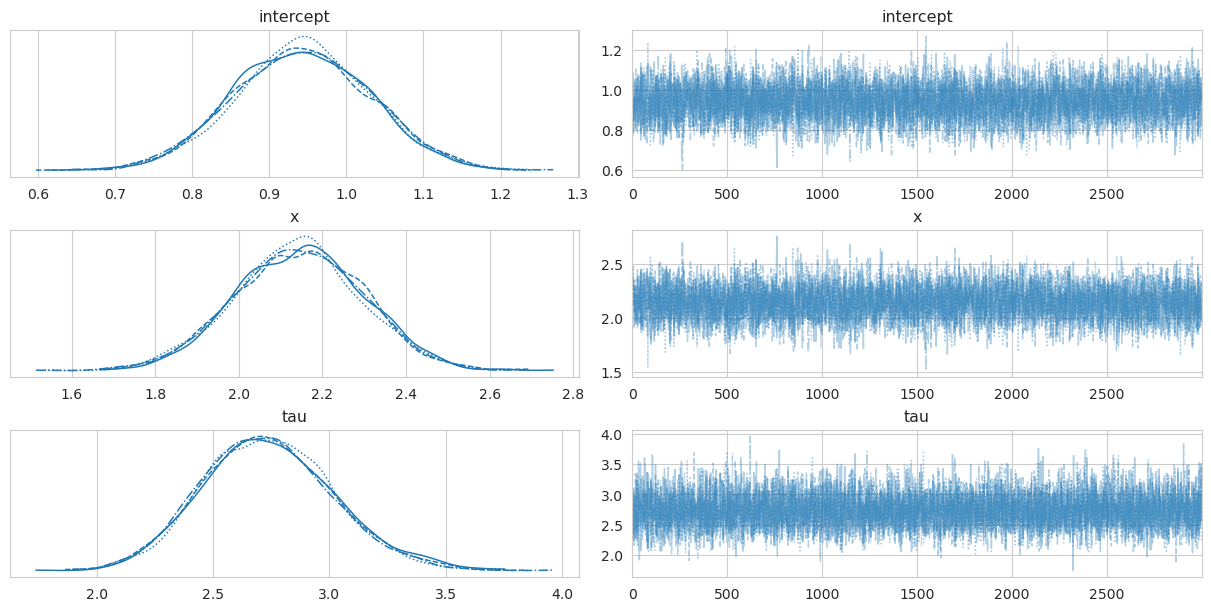

In [69]:
_ = ar.plot_trace(trace, lines={"intercept": 0})

### Gleman Radon Heirarchical Model

In [116]:
data = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc4/master/notebooks/data/radon.csv', index_col=0)

<AxesSubplot:xlabel='log_radon', ylabel='Density'>

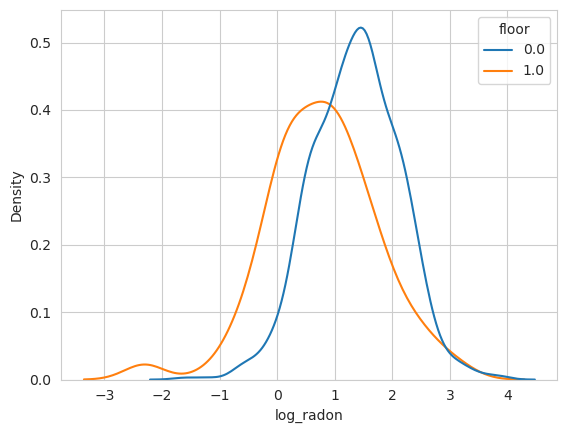

In [31]:
sns.kdeplot(data=data, hue='floor', x='log_radon', common_norm=False)

In [137]:
from pymc3 import Model, Normal, Gamma, Data

# unpooled/individual regression
county_idices, counties = pd.factorize(data.county)
coords = {
    'county': counties,
    'obs_id': np.arange(county_idices.shape[0])
}

with Model(coords=coords) as model:
    county_idx = Data("county_idx", county_idices, dims='obs_id')
    floor = Data("floor", data.floor.values, dims='obs_id')

    β0 = Normal("beta0", mu=0, tau=1/10000, dims='county')
    β1 = Normal("beta1", mu=0, tau=1/10000, dims='county')
    tau = Gamma("tau", alpha=1, beta=100)

    radon_est = β0[county_idx] + β1[county_idx] * floor

    likelihood = Normal("y", mu=radon_est, tau=tau, observed=data.log_radon, dims='obs_id')

In [141]:
with model:
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta1, beta0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


0, dim: obs_id, 919 =? 919


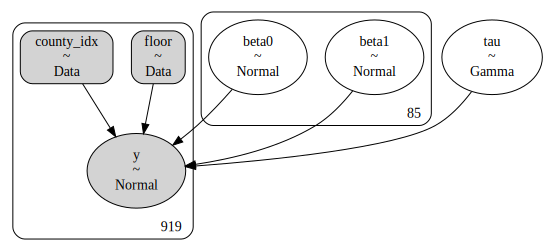

In [144]:
pm.model_to_graphviz(model)

In [156]:
from pymc3 import Model, Normal, Gamma, Data

# unpooled/individual regression
county_idices, counties = pd.factorize(data.county)
coords = {
    'county': counties,
    'obs_id': np.arange(county_idices.shape[0])
}

with Model(coords=coords) as model:
    county_idx = Data("county_idx", county_idices, dims='obs_id')
    floor = Data("floor", data.floor.values, dims='obs_id')
    
    β0 = Normal(
        "beta0",
        mu=Normal("mu0", mu=0, sigma=100),
        tau=Gamma("tau0", alpha=1, beta=25),
        dims='county'
    )
    β1 = Normal(
        "beta1",
        mu=Normal("mu1", mu=0, sigma=100),
        tau=Gamma("tau1", alpha=1, beta=25),
        dims='county'
    )
    tau = Gamma("tau", alpha=1, beta=100)

    radon_est = β0[county_idx] + β1[county_idx] * floor

    likelihood = Normal("y", mu=radon_est, tau=tau, observed=data.log_radon, dims='obs_id')

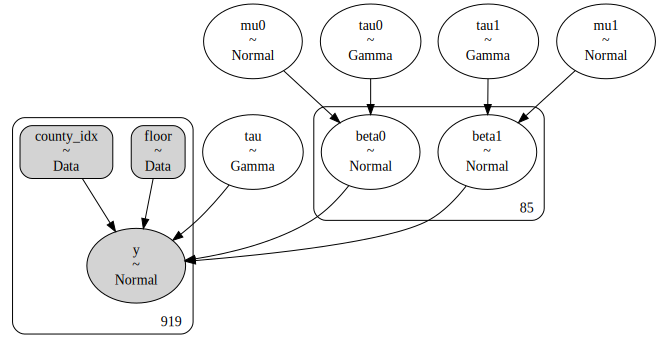

In [157]:
pm.model_to_graphviz(model)

In [160]:
with model:
    trace = pm.sample(10000, tune=5000, return_inferencedata=True, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta1, tau1, mu1, beta0, tau0, mu0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 26 seconds.


0, dim: obs_id, 919 =? 919


array([[<AxesSubplot:title={'center':'mu0'}>,
        <AxesSubplot:title={'center':'mu0'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'tau0'}>,
        <AxesSubplot:title={'center':'tau0'}>],
       [<AxesSubplot:title={'center':'tau1'}>,
        <AxesSubplot:title={'center':'tau1'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

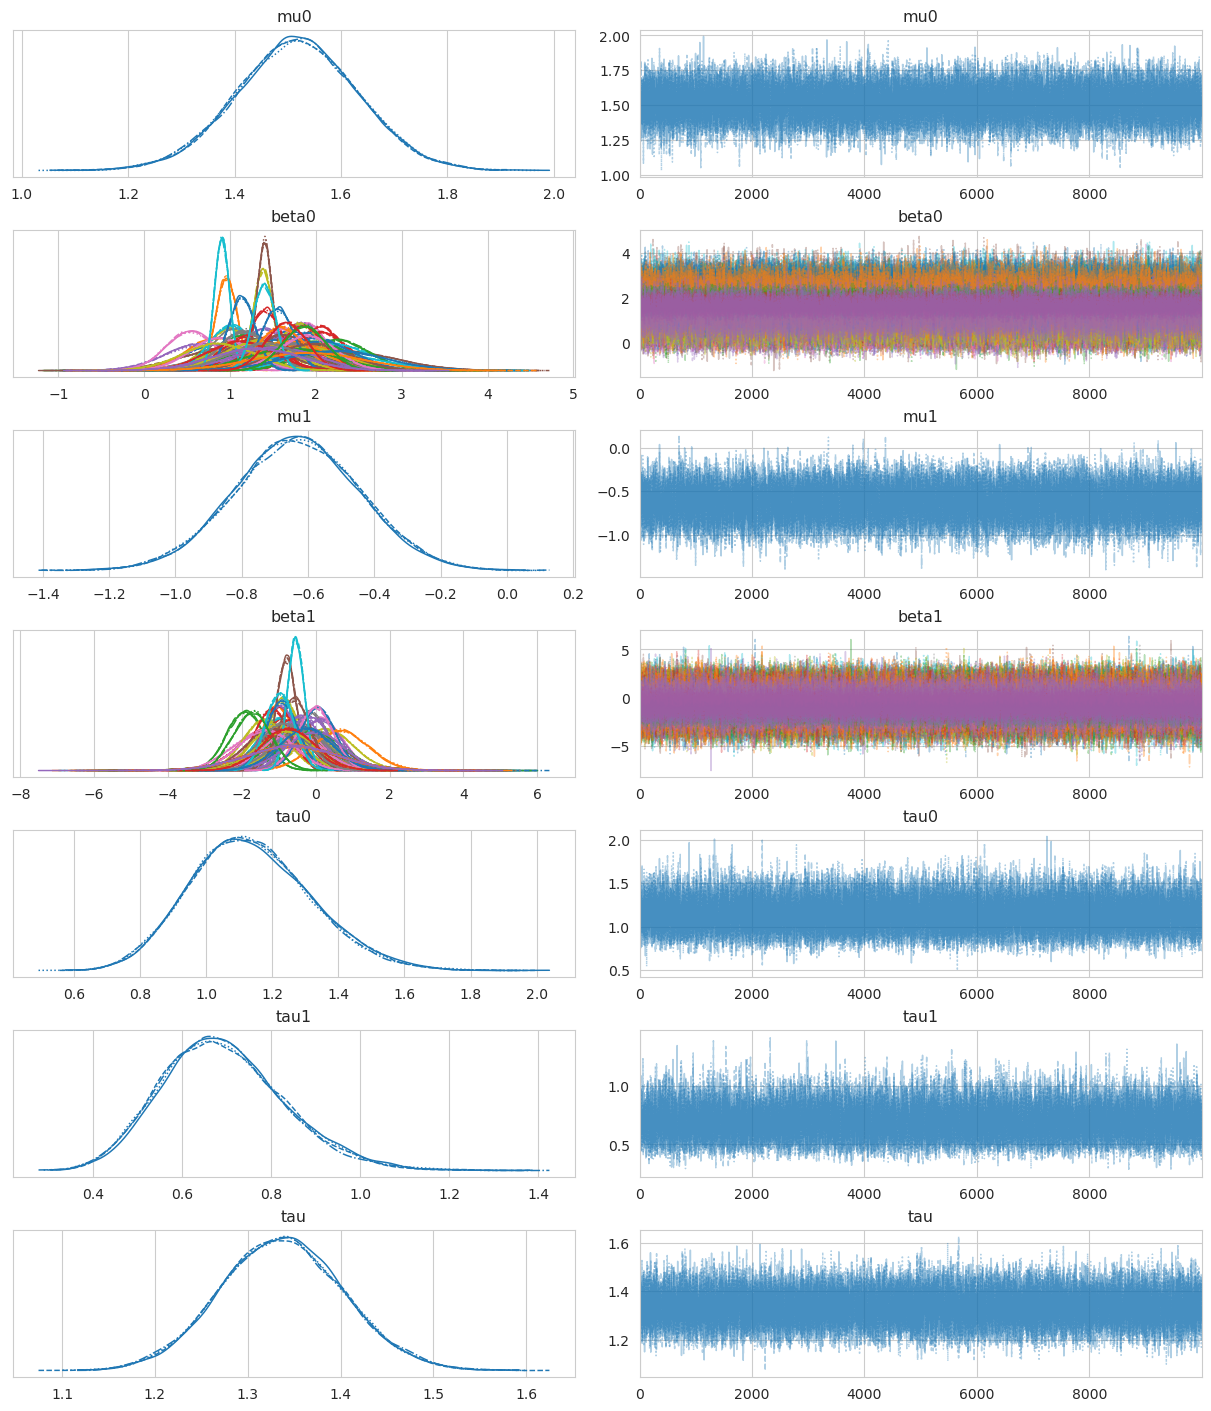

In [161]:
ar.plot_trace(trace)

### AR(1) Model

Text(0, 0.5, '$y$')

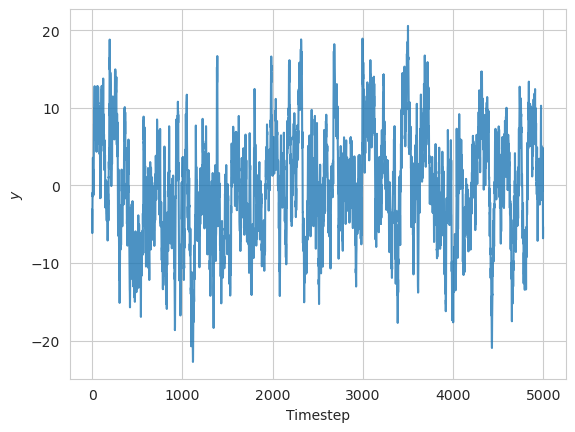

In [162]:
T = 10000
y = np.zeros((T,))

# true stationarity:
true_theta = 0.95
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = 0.0

for t in range(1, T):
    y[t] = true_theta * y[t - 1] + np.random.normal(loc=true_center, scale=true_sigma)

y = y[-5000:]
plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$")

In [179]:
from pymc3 import Model, Normal, Exponential, AR1

with Model() as ar1:
    theta = Normal("theta", mu=0., sigma=1.)
    tau = Exponential("tau", 0.5)
    center = Normal("center", mu=0., sigma=1.)

    likelihood = AR1("y", k=theta, tau_e=tau, observed=y-center)

In [180]:
with ar1:
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [center, tau, theta]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'center'}>,
        <AxesSubplot:title={'center':'center'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

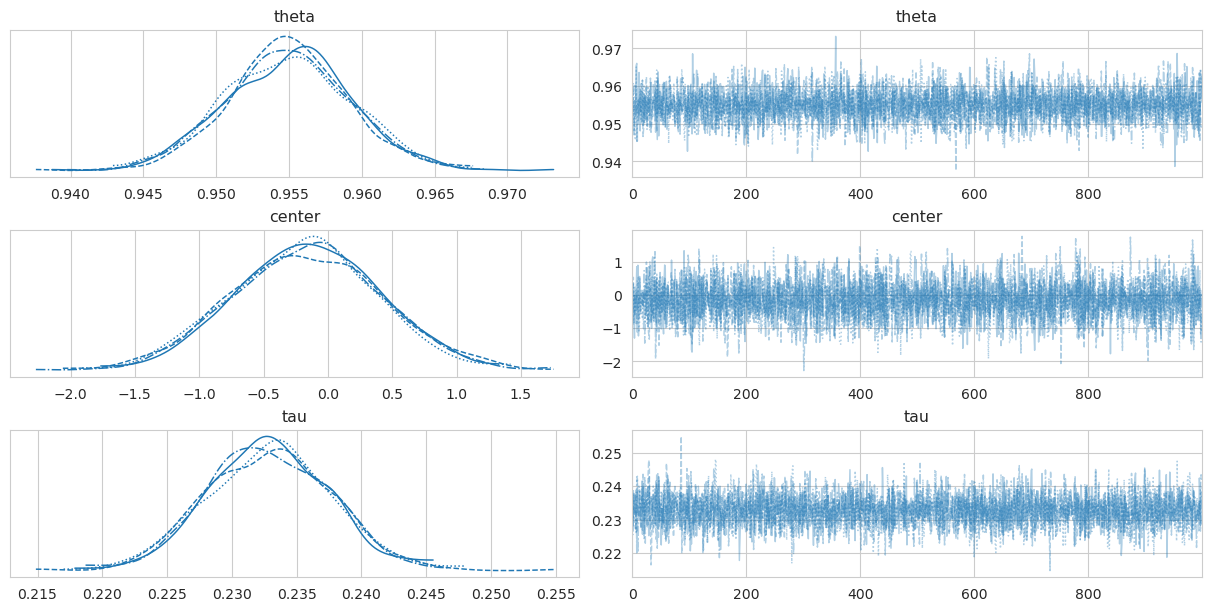

In [181]:
ar.plot_trace(trace)

### Time Variant Transition Matrix HMM Guassian Observations

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import patsy
import theano
import theano.tensor as tt

from theano import shared
from pymc3 import Model, Normal, Gamma, Dirichlet
from pymc3_hmm.utils import multilogit_inv, compute_steady_state
from pymc3_hmm.distributions import SwitchingProcess, DiscreteMarkovChain
from pymc3_hmm.step_methods import FFBSStep

In [165]:
def create_normal_mixture_hmm_tv(X_tt, mu_1, mu_2, θks, pi_0, observed=None):
    """
    parameters:
    -----------
    X_tt: the design matrix
    mu_1, mu_2: float, the mu parameter of the possion process at individual state
    θks: the parameter matrix for the transition matrix
    pi_0: the initial state distirubtion
    observed: the observation series
    """
    # construct he transition matrix
    # it is fully determistic if the θ is known
    z_tt = multilogit_inv(tt.tensordot(X_tt, θks, axes=((1,), (0,))))
    P_rv = pm.Deterministic("P_t", z_tt)

    # the 1-st order MM of the hidden state
    S_rv = DiscreteMarkovChain("S_t", P_rv, pi_0, shape=np.shape(observed)[-1])

    Y_rv = SwitchingProcess(
        "Y_t",
        [pm.Normal.dist(mu_1, 10), pm.Normal.dist(mu_2, 10)],
        S_rv,
        observed=observed,
    )
    return Y_rv

In [4]:
np.random.seed(2032)

# building the design matrix on weekday dummies
start_date = pd.Timestamp("2020-01-01 00:00:00")
time_index = pd.date_range(start=start_date, end=start_date + pd.Timedelta("30W"), inclusive="left", freq="1h")
X_df = patsy.dmatrix(
    formula_like="~ 1 + C(weekday)",
    data=pd.DataFrame({"weekday": time_index.weekday}, index=time_index),
    return_type="dataframe"
)

# The coefficients used to compute the state zero-to-zero transition probabilities
θk_0_true = pd.Series(np.array([2.0, -5.0, -3.0, 0.0, 0.0, -5.0, 5.0]), index=X_df.columns)
# The coefficients for the state one-to-zero transition probabilities
θk_1_true = pd.Series(np.array([2.0, -1.0, 3.0, 0.0, 0.0, -5.0, 5.0]), index=X_df.columns)

θks_true = tt.as_tensor(np.stack([θk_0_true, θk_1_true], axis=1)[..., None], name="xis")

mu_1_true, mu_2_true = 60, 10 # mean for each state
p_0_true = tt.as_tensor(np.r_[0.0, 1.0]) # the initial state distribution

X_tt = theano.shared(X_df.values, borrow=True)

In [5]:
with pm.Model() as sim_model:
    _ = create_normal_mixture_hmm_tv(
        X_tt, mu_1_true, mu_2_true, θks_true, p_0_true,
        observed=np.zeros(X_df.shape[0])
    )

In [6]:
sim_point = pm.sample_prior_predictive(samples=1, model=sim_model)
y_t = sim_point["Y_t"].squeeze()

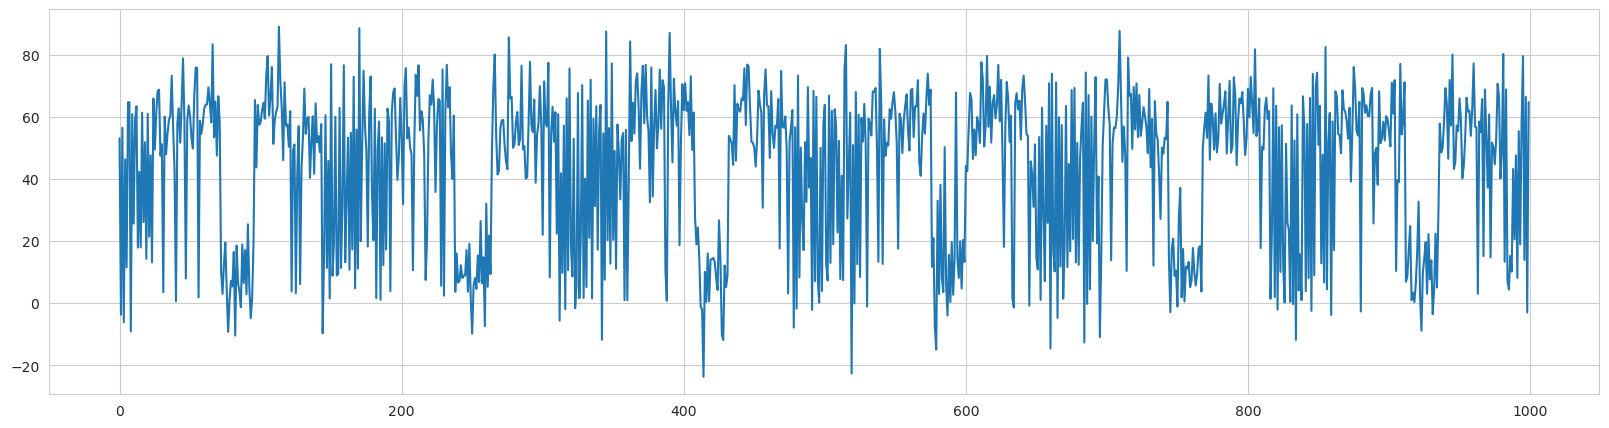

In [30]:
plt.subplots(figsize=(20, 5))
plt.plot(y_t[:1000])

In [22]:
with pm.Model(theano_config={"compute_test_value": "ignore"}) as test_model:
    # observation mean priors
    E_mu, Var_mu = 10.0, 10000.0
    μ1_rv = pm.Normal("μ1", E_mu, np.sqrt(Var_mu))
    μ2_rv = pm.Normal("μ2", 2*E_mu, np.sqrt(Var_mu))

    # initial state distribution prior
    π0_rv = pm.Dirichlet("π0", np.r_[1, 1])

    # state transition parameter prior
    θks_rv = pm.Normal("θks", 0, 10, shape=(X_df.shape[1], 2, 1))

    _ = create_normal_mixture_hmm_tv(X_tt, μ1_rv, μ2_rv, θks_rv, π0_rv, y_t)

In [26]:
with test_model:
    states_step = FFBSStep([test_model.S_t])
    mu_step = pm.NUTS(
        [test_model.μ1, test_model.μ2, test_model.θks, test_model.π0]
    )

    posterior_trace = pm.sample(
        step=[states_step, mu_step],
        return_inferencedata=True,
        chains=1,
        progressbar=True,
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 306 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

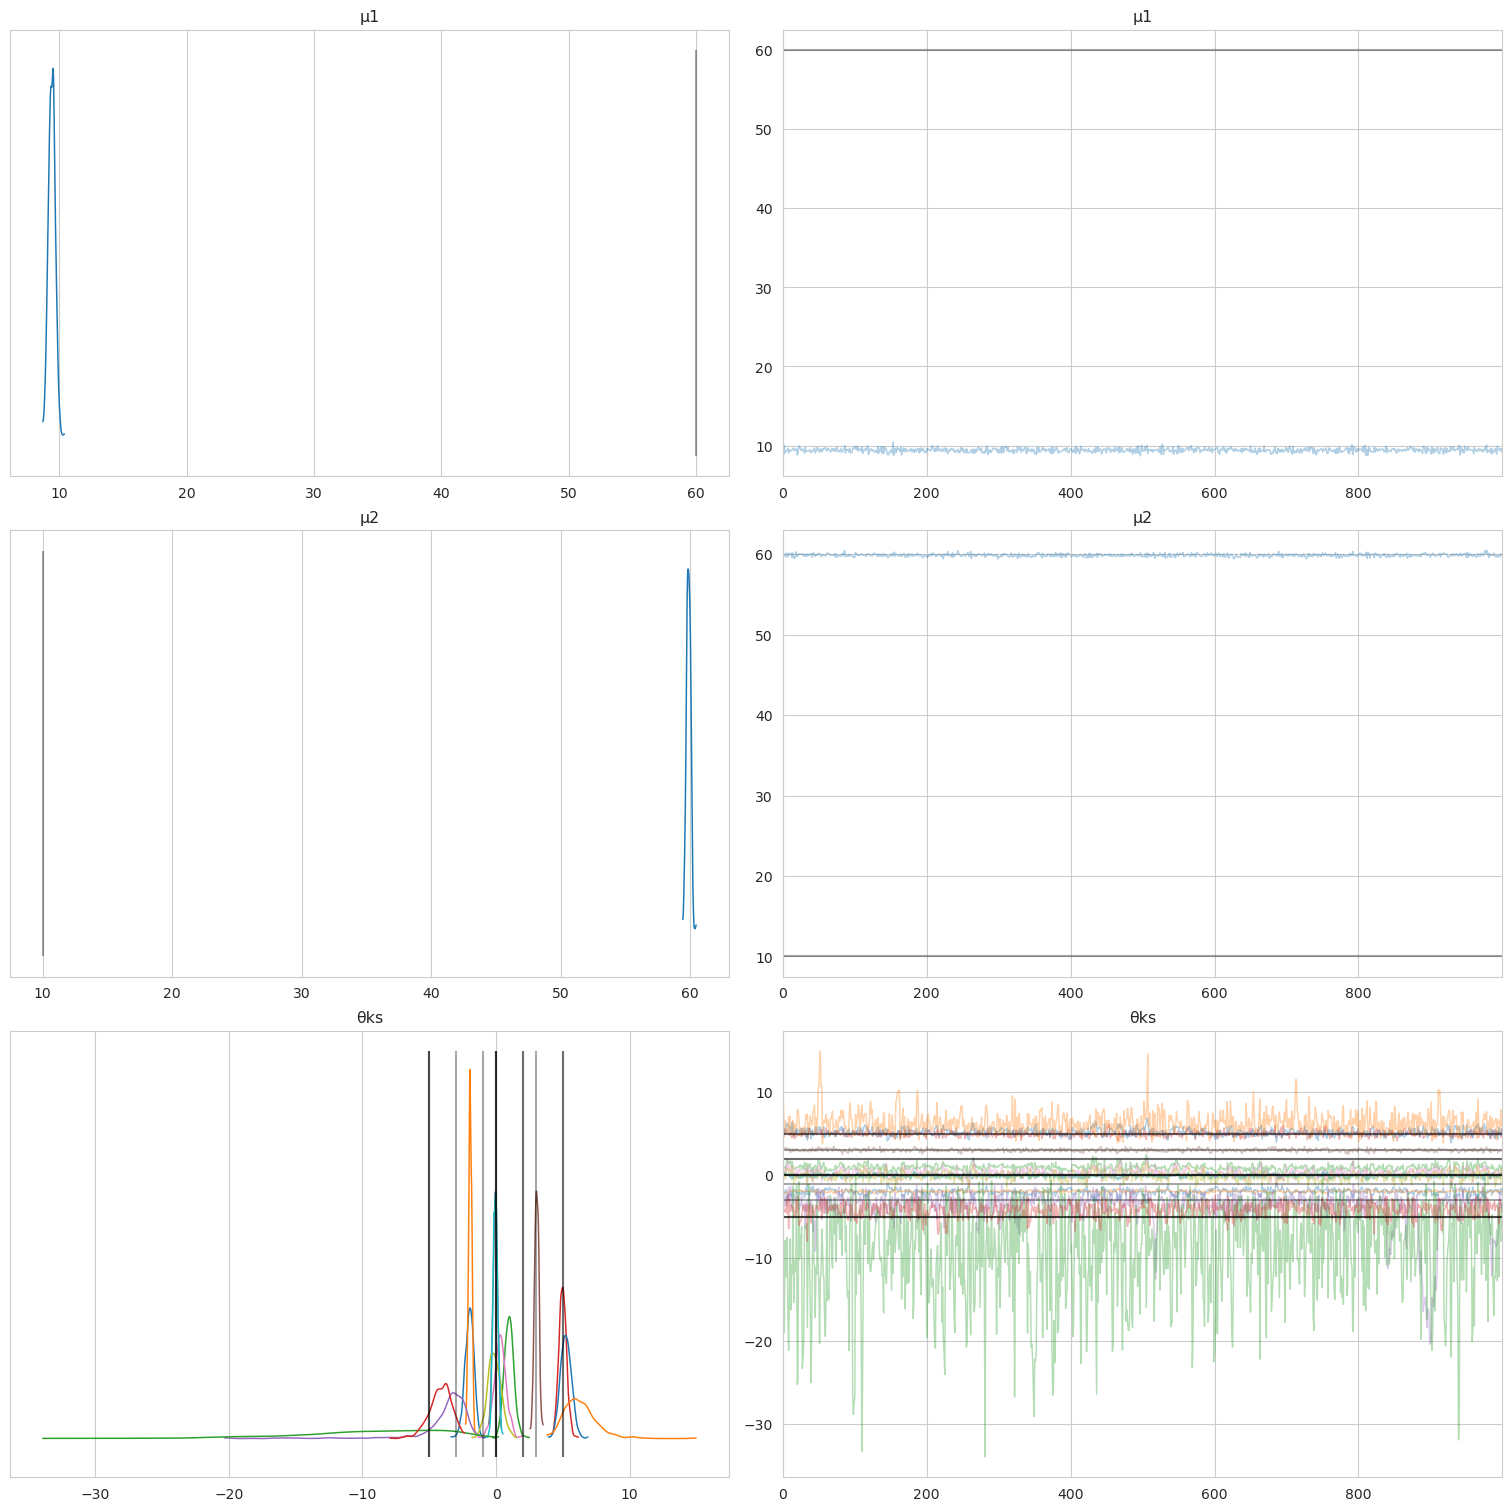

In [28]:
ax = ar.plot_trace(
    posterior_trace.posterior,
    var_names=["μ1", "μ2", "θks"],
    lines=[
        ("μ1", {}, [mu_1_true]),
        ("μ2", {}, [mu_2_true]),
        ("θks", {}, [θks_true.data]),
    ],
    compact=True,
    figsize=(15, 15),
)

In [32]:
with test_model:
    posterior_pred_trace = pm.sample_posterior_predictive(posterior_trace.posterior, var_names=["S_t", "Y_t"])

<AxesSubplot:xlabel='level_1', ylabel='0'>

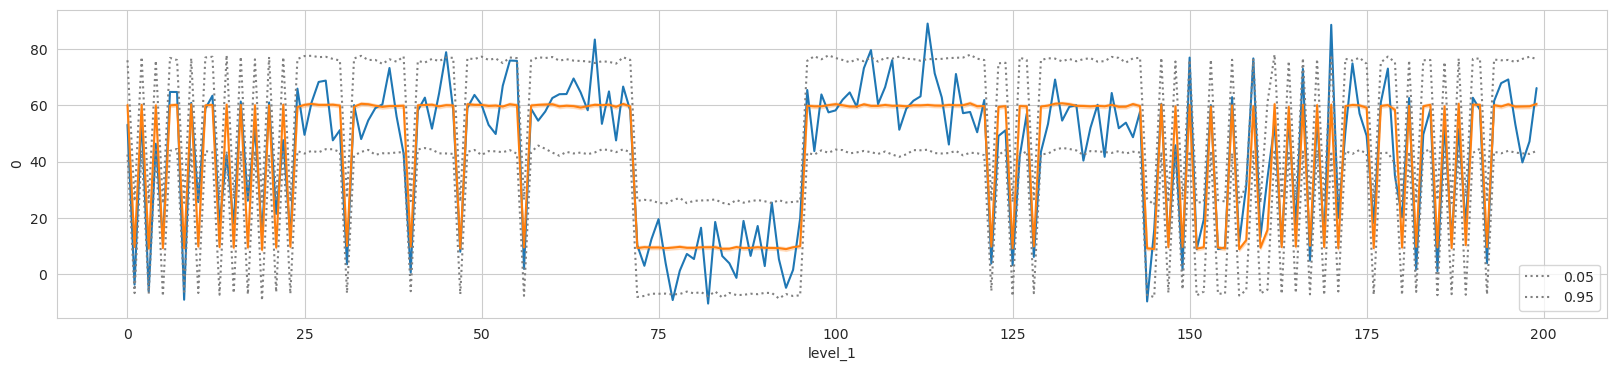

In [101]:
_, ax = plt.subplots(figsize=(20, 4))
pd.Series(y_t[:200]).plot(ax=ax)
sns.lineplot(data=pd.DataFrame(posterior_pred_trace['Y_t'][:,:200]).stack().reset_index(level=1).reset_index(drop=True), x='level_1', y=0, ax=ax)
pd.DataFrame(posterior_pred_trace['Y_t'][:,:200]).quantile([0.05, 0.95], axis=0).T.plot(color='grey', ls=':', ax=ax)

In [121]:
start_date_oos = time_index[-1]
time_index_oos = pd.date_range(start=start_date_oos, end=start_date_oos + pd.Timedelta("5W"), inclusive="left", freq="1h")
X_oos_df = patsy.dmatrix(
    formula_like="~ 1 + C(weekday)",
    data=pd.DataFrame({"weekday": time_index_oos.weekday}, index=time_index_oos),
    return_type="dataframe"
)

X_tt.set_value(X_oos_df.values)

with test_model:
    test_model.S_t.distribution.shape = (X_oos_df.shape[0], )

    out_of_sample_pp = pm.sample_posterior_predictive(posterior_trace.posterior.drop_vars(["S_t", "P_t"]), var_names=["S_t", "P_t", "Y_t"])

In [122]:
pd.DataFrame(out_of_sample_pp['Y_t'])

,0,1,2,3,4,5,6,7,8,9,...,830,831,832,833,834,835,836,837,838,839
0,-7.701382,44.004911,19.331741,43.642338,-1.472022,66.457630,65.833272,1.562504,58.966916,77.729112,...,31.546486,52.853362,2.110910,58.581666,10.905772,56.003857,15.308868,-6.132341,54.361936,7.043640
1,60.168297,20.737267,73.911302,56.977617,1.962042,55.030835,13.996256,60.492349,92.763936,1.265493,...,67.407679,15.575295,58.714107,5.347427,53.522035,12.226138,-13.614061,59.393891,3.225511,41.408223
2,54.908169,15.495451,48.772268,6.321855,58.667888,72.499534,71.825105,23.688813,63.001434,-10.712452,...,7.041084,13.271967,80.313622,9.428813,61.139133,8.693338,9.156947,14.013729,64.101125,45.621495
3,17.297662,67.573213,14.203234,63.777277,5.096216,54.331045,53.337983,-1.487318,64.974130,4.668271,...,21.851876,13.079060,47.702344,12.616500,11.227561,58.032833,-8.033693,17.406251,54.992843,10.488300
4,52.066358,11.449492,47.646551,49.923472,-6.449926,62.843671,2.826448,46.119529,69.223368,64.878368,...,5.564406,53.875136,5.797821,71.921574,11.832908,70.466081,5.700918,19.426910,65.601356,12.026375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60.607028,65.814393,1.654586,60.735137,-5.977304,75.492504,23.967522,45.275884,61.443113,5.937506,...,82.904199,-0.914164,75.029036,18.545042,70.707599,5.608712,71.740472,11.708554,49.937774,-0.239530
996,70.284776,12.877506,47.203177,11.324041,58.474990,-12.302954,40.195501,12.852308,49.778659,59.230309,...,5.923436,15.211580,63.464494,13.306383,-0.912057,73.394719,13.234946,-0.743261,57.063543,10.961885
997,61.920954,-16.228042,44.828232,-6.774994,4.641103,75.410079,10.296404,77.116531,50.657410,52.375037,...,13.802814,58.780583,1.308423,60.107109,6.884292,4.939916,5.209356,77.217740,20.084456,61.960265
998,25.353048,62.269335,4.534834,55.964877,-5.548078,78.419680,9.667462,55.488430,0.703332,55.824997,...,3.543447,22.413474,15.924828,60.338072,25.719409,76.128381,66.378207,9.944059,49.616538,3.253716


<AxesSubplot:xlabel='level_1', ylabel='0'>

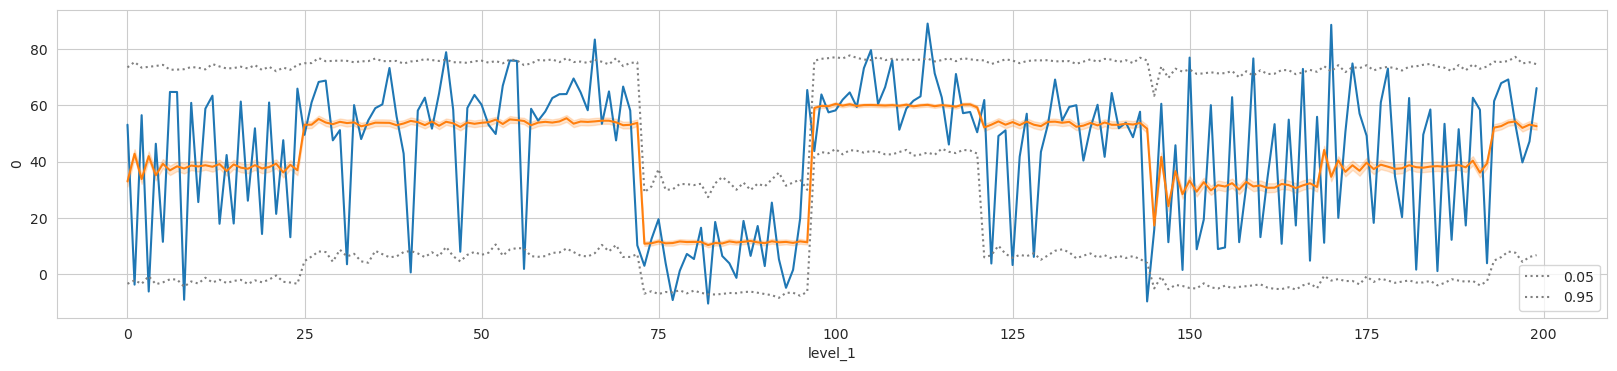

In [124]:
_, ax = plt.subplots(figsize=(20, 4))
pd.Series(y_t[:200]).plot(ax=ax)
sns.lineplot(data=pd.DataFrame(out_of_sample_pp['Y_t'][:,:200]).stack().reset_index(level=1).reset_index(drop=True), x='level_1', y=0, ax=ax)
pd.DataFrame(out_of_sample_pp['Y_t'][:,:200]).quantile([0.05, 0.95], axis=0).T.plot(color='grey', ls=':', ax=ax)

### Time Invariant HMM with Gaussian Linear Regression Observation

In [315]:
import numpy as np
import pandas as pd
import pymc3 as pm
import patsy
import theano
import theano.tensor as tt

from pymc3 import Model, Data, Normal, Gamma, Dirichlet, Deterministic
from pymc3_hmm.utils import compute_steady_state
from pymc3_hmm.distributions import SwitchingProcess, DiscreteMarkovChain
from pymc3_hmm.step_methods import FFBSStep

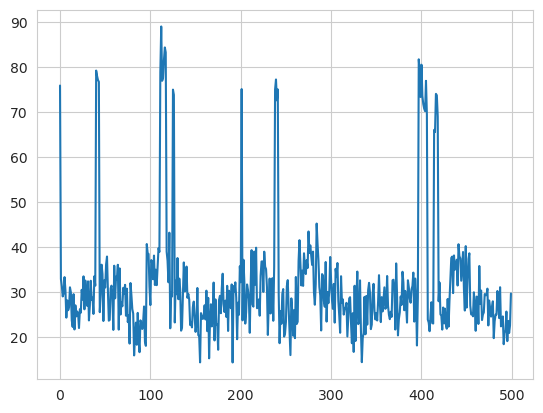

In [236]:
np.random.seed(2032)

# building the design matrix on weekday dummies
start_date = pd.Timestamp("2020-01-01 00:00:00")
time_index = pd.date_range(start=start_date, end=start_date + pd.Timedelta("5W"), inclusive="left", freq="1h")
X_df = patsy.dmatrix(
    formula_like="~ 1 + C(weekday)",
    data=pd.DataFrame({"weekday": time_index.weekday}, index=time_index),
    return_type="dataframe"
)

# The coefficients for observation model
θ1_true = pd.Series(np.array([30.0, -5.0, -3.0, 0.0, 0.0, -5.0, 5.0]), index=X_df.columns)
θ2_true = pd.Series(np.array([75.0, -1.0, 3.0, 0.0, 0.0, -5.0, 5.0]), index=X_df.columns)

mu_1_true = tt.tensordot(X_df, θ1_true, axes=((1,), (0,)))
tau_1_true, tau_2_true = 1/20, 1/20
mu_2_true = tt.tensordot(X_df, θ2_true, axes=((1,), (0,)))

A0_true = np.array([0.98, 0.02])
A1_true = np.array([0.3, 0.7])

with pm.Model() as sim_model:
    A_rv = pm.Deterministic("A_t", tt.shape_padleft(tt.stack([A0_true, A1_true])))
    π = compute_steady_state(A_rv)

    # the 1-st order MM of the hidden state
    S_rv = DiscreteMarkovChain("S_t", A_rv, π, shape=X_df.shape[0])

    # likelihood that calculates the conditional density on the hidden state
    Y_rv = SwitchingProcess(
        "Y_t",
        [pm.Normal.dist(mu=mu_1_true, tau=tau_1_true), pm.Normal.dist(mu=mu_2_true, tau=tau_2_true)],
        S_rv,
        observed=np.zeros(X_df.shape[0]),
    )

sim_point = pm.sample_prior_predictive(samples=1, model=sim_model)
y_t = sim_point["Y_t"].squeeze()

plt.plot(y_t[:500])

In [ ]:
def create_arx_hmm_model(X, y=None):
    """
    Create the graph for AutoRegressive with Extra Input on Hidden Markov Model (ARX-HMM)
    """
    with pm.Model() as model:
        X_tt = pm.Data("data", X)

        # linear regression conditional on hidden states
        β1 = Normal("β1", 0, tau=1/100, shape=X.shape[1])
        β2 = Normal("β2", 0, tau=1/100, shape=X.shape[1])

        conditional_dists = [
            Normal.dist(
                mu=tt.tensordot(X_tt, β1, axes=((1,), (0,))),
                tau=Gamma("τ1", alpha=1, beta=1/20)
            ),
            Normal.dist(
                mu=tt.tensordot(X_tt, β2, axes=((1,), (0,))),
                tau=Gamma("τ2", alpha=1, beta=1/20)
            ),
        ]

        # time invariant state transition prior
        A0 = Dirichlet("A0", np.r_[1, 1])
        A1 = Dirichlet("A1", np.r_[1, 1])
        A = Deterministic("A_t", tt.shape_padleft(tt.stack([A0, A1])))

        # initial hidden state prior
        π = compute_steady_state(A)

        # the 1-st order MM of the hidden state
        S_rv = DiscreteMarkovChain("S_t", A, π, shape=X.shape[0])

        # likelihood that calculates the conditional density on the hidden state
        observed = np.zeros(X.shape[0]) if y is None else y  # dummy placeholder
        likelihood = SwitchingProcess("Y_t", conditional_dists, S_rv, observed=observed)
    
    return model

In [347]:
train_model = create_arx_hmm_model(X_df, y_t)

In [351]:
with train_model:
    states_step = FFBSStep([train_model.S_t])
    mu_step = pm.NUTS([
        train_model.β1, train_model.β2,
        train_model.τ1, train_model.τ2,
        train_model.A0, train_model.A1
    ])

    posterior_trace = pm.sample(
        2000, tune=1000,
        step=[states_step, mu_step],
        return_inferencedata=True,
        chains=1,
        progressbar=True,
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.t

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 119 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

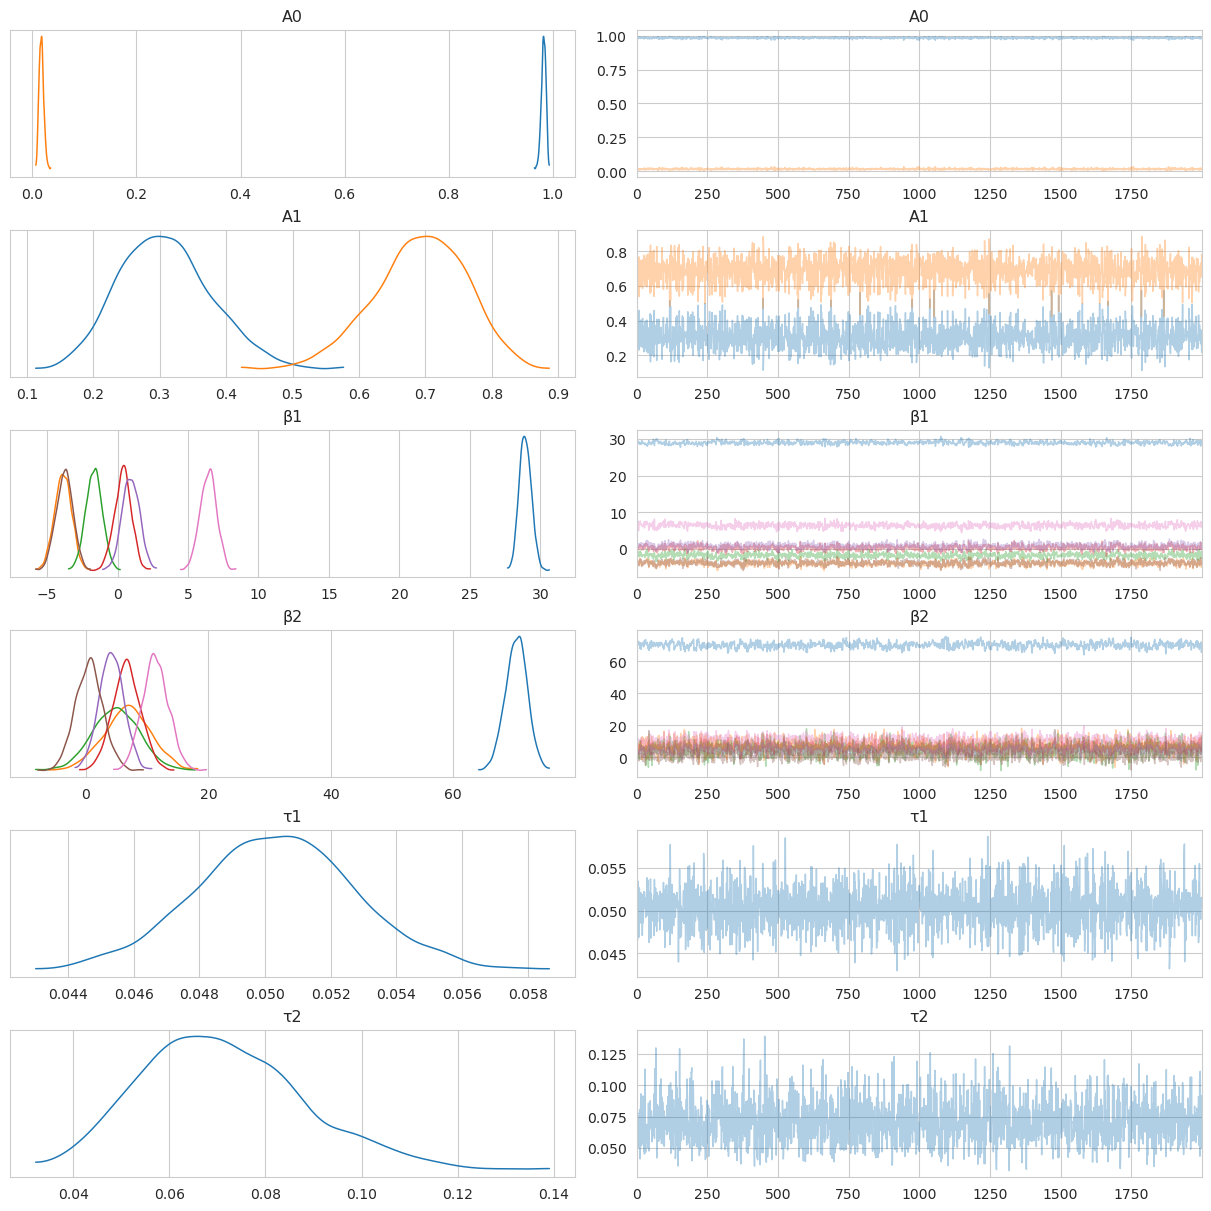

In [353]:
ax = ar.plot_trace(posterior_trace, var_names=["A0", "A1", 'β1', 'β2', 'τ1', 'τ2'])

In [341]:
start_date_oos = time_index[-1]
time_index_oos = pd.date_range(start=start_date_oos, end=start_date_oos + pd.Timedelta("2W"), inclusive="left", freq="1h")
X_oos_df = patsy.dmatrix(
    formula_like="~ 1 + C(weekday)",
    data=pd.DataFrame({"weekday": time_index_oos.weekday}, index=time_index_oos),
    return_type="dataframe"
)

t_model = create_arx_hmm_model(X_oos_df, y=None)
out_of_sample_pp = pm.sample_posterior_predictive(
    trace=posterior_trace.posterior.drop_vars(["S_t"]), var_names=["Y_t"],
    samples=2000, model=t_model
)

<AxesSubplot:xlabel='level_1', ylabel='0'>

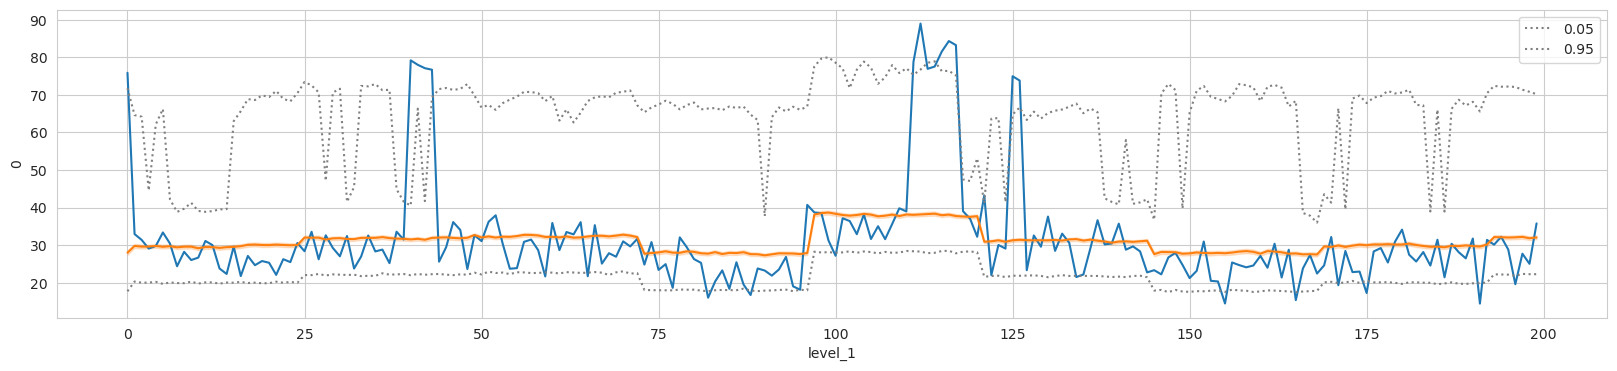

In [312]:
_, ax = plt.subplots(figsize=(20, 4))
pd.Series(y_t[:200]).plot(ax=ax)
sns.lineplot(data=pd.DataFrame(out_of_sample_pp['Y_t'][:,:200]).stack().reset_index(level=1).reset_index(drop=True), x='level_1', y=0, ax=ax)
pd.DataFrame(out_of_sample_pp['Y_t'][:,:200]).quantile([0.05, 0.95], axis=0).T.plot(color='grey', ls=':', ax=ax)